In [8]:
!pip install seaborn


In [2]:
import sys
!{sys.executable} -m pip install azure-ai-ml azure-identity --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-exporter-prometheus 0.56b0 requires opentelemetry-sdk~=1.35.0, but you have opentelemetry-sdk 1.38.0 which is incompatible.
mlflow-skinny 2.21.3 requires packaging<25, but you have packaging 25.0 which is incompatible.
jupyterlab-nvdashboard 0.13.0 requires jupyterlab>=4, but you have jupyterlab 3.6.8 which is incompatible.
jupyter-resource-usage 0.7.2 requires psutil~=5.6, but you have psutil 7.1.3 which is incompatible.
dask-sql 2024.5.0 requires dask[dataframe]>=2024.4.1, but you have dask 2023.2.0 which is incompatible.
dask-sql 2024.5.0 requires distributed>=2024.4.1, but you have distributed 2023.2.0 which is incompatible.
azureml-training-tabular 1.60.0 requires psutil<5.9.4,>=5.2.2, but you have psutil 7.1.3 which is incompatible.
azureml-training-tabular 1.60.0 requires scipy<1.11.0,>=1.0.0,

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.ensemble import IsolationForest


In [2]:
ml_client = MLClient(
    DefaultAzureCredential(),
    subscription_id="70c34068-eea9-44dd-a857-783e7a7561bb", 
    resource_group_name="rg-diabetes-project",                
    workspace_name="ws-diabetes"                              
)

data_asset = ml_client.data.get(name="diabetes_dataset", label="latest")

local_path = data_asset.path
print(" Dataset trouvé :", local_path)




Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


 Dataset trouvé : https://huggingface.co/datasets/marianeft/diabetes_prediction_dataset/resolve/main/diabetes_prediction_dataset.csv



In [4]:
df = pd.read_csv(local_path)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
print("Dimensions du dataset :", df.shape)
print("\nAperçu des données :")
display(df.head())

Dimensions du dataset : (100000, 9)

Aperçu des données :


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [58]:
print("\nStatistiques descriptives :")
display(df.describe())


Statistiques descriptives :


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [5]:
print("\nValeurs manquantes :")
print(df.isnull().sum())


Valeurs manquantes :
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


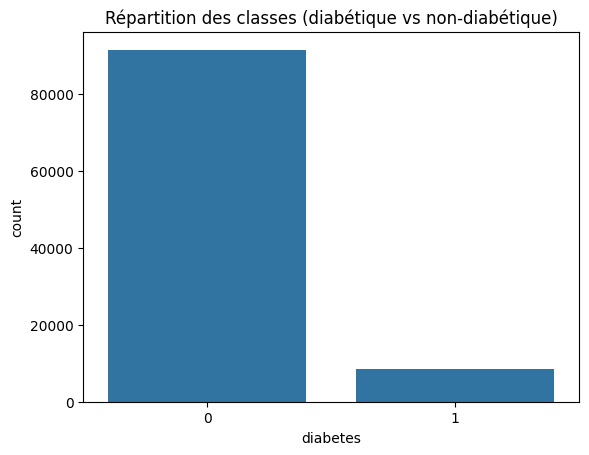

In [60]:
sns.countplot(x='diabetes', data=df)
plt.title("Répartition des classes (diabétique vs non-diabétique)")
plt.show()

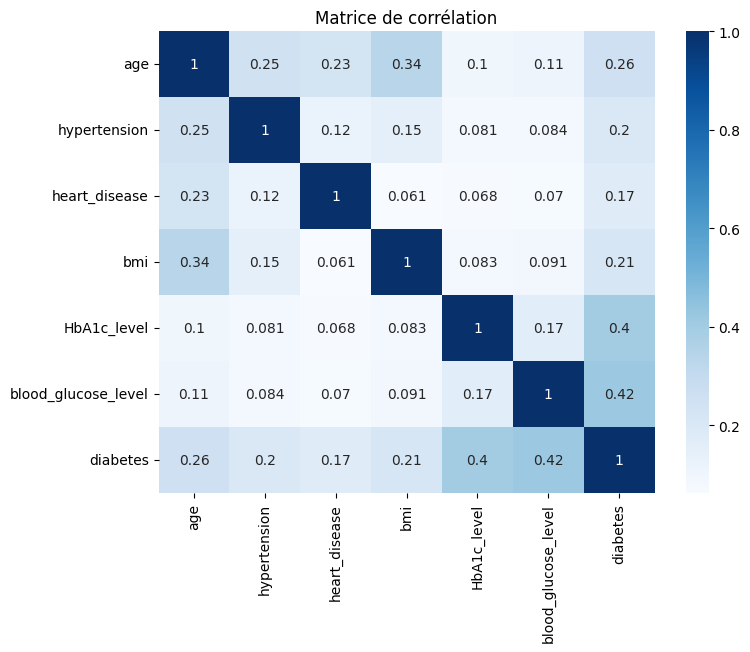

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title("Matrice de corrélation")
plt.show()

In [7]:
print("=== Valeurs uniques AVANT nettoyage ===")
print(df['smoking_history'].value_counts())


=== Valeurs uniques AVANT nettoyage ===
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64


In [5]:
nb_no_info = (df['smoking_history'] == "No Info").sum()
print(f"Nombre de lignes avec 'No Info' : {nb_no_info}")

Nombre de lignes avec 'No Info' : 35816


In [6]:
df['smoking_history'] = df['smoking_history'].replace("No Info", "unknown")

print("\n=== Valeurs uniques APRÈS nettoyage ===")
print(df['smoking_history'].value_counts())


=== Valeurs uniques APRÈS nettoyage ===
unknown        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64


In [7]:
pourcentage_unknown = (df['smoking_history'] == "unknown").mean() * 100
print(f"\nPourcentage de 'unknown' dans le dataset : {pourcentage_unknown:.2f}%")


Pourcentage de 'unknown' dans le dataset : 35.82%


In [8]:
categorical_cols = ['gender', 'smoking_history']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print("=== Dimensions du dataset avant encodage ===")
print(df.shape)
print("\n=== Dimensions du dataset après encodage ===")
print(df_encoded.shape)

print("\n=== Nouvelles colonnes créées ===")
print([col for col in df_encoded.columns if 'gender_' in col or 'smoking_history_' in col])


=== Dimensions du dataset avant encodage ===
(100000, 9)

=== Dimensions du dataset après encodage ===
(100000, 16)

=== Nouvelles colonnes créées ===
['gender_Female', 'gender_Male', 'gender_Other', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current', 'smoking_history_unknown']


In [9]:
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(df_encoded[numeric_features])

iso_labels = iso_forest.predict(df_encoded[numeric_features])

df_if = df_encoded.copy()
df_if['outlier_iforest'] = iso_labels 

In [10]:
df_iqr = df_encoded.copy()
df_iqr['outlier_iqr'] = 0  

for col in numeric_features:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_iqr['outlier_iqr'] = df_iqr['outlier_iqr'] | ((df_iqr[col] < lower) | (df_iqr[col] > upper))


In [11]:
df_outliers_compare = df_encoded.copy()
df_outliers_compare['outlier_iforest'] = iso_labels
df_outliers_compare['outlier_iqr'] = df_iqr['outlier_iqr']

df_outliers_compare['outlier_both'] = (
    (df_outliers_compare['outlier_iforest'] == -1) &
    (df_outliers_compare['outlier_iqr'] == 1)
)


In [12]:
print("\nNombre d'outliers (Isolation Forest seul) :", (df_outliers_compare['outlier_iforest'] == -1).sum())
print("Nombre d'outliers (IQR seul) :", (df_outliers_compare['outlier_iqr'] == 1).sum())
print("Nombre d'outliers communs (IF + IQR) :", df_outliers_compare['outlier_both'].sum())



Nombre d'outliers (Isolation Forest seul) : 20664
Nombre d'outliers (IQR seul) : 18048
Nombre d'outliers communs (IF + IQR) : 15247


In [13]:
print(df_outliers_compare[df_outliers_compare['outlier_both'] == True]['diabetes'].value_counts())


0    10022
1     5225
Name: diabetes, dtype: int64


In [14]:
diab_outliers = df_outliers_compare[
    (df_outliers_compare['diabetes'] == 1) &
    (df_outliers_compare['outlier_iforest'] == -1)
]

diab_normal = df_outliers_compare[
    (df_outliers_compare['diabetes'] == 1) &
    (df_outliers_compare['outlier_iforest'] == 1)
]

print("Nombre de diabétiques OUTLIERS :", len(diab_outliers))
print("Nombre de diabétiques NON-outliers :", len(diab_normal))


Nombre de diabétiques OUTLIERS : 5633
Nombre de diabétiques NON-outliers : 2867


In [15]:
print("\n📌 Moyennes des traits des DIABÉTIQUES OUTLIERS")
print(diab_outliers[numeric_features].describe())

print("\n📌 Moyennes des traits des DIABÉTIQUES NON OUTLIERS")
print(diab_normal[numeric_features].describe())



📌 Moyennes des traits des DIABÉTIQUES OUTLIERS
               age  hypertension  heart_disease          bmi  HbA1c_level  \
count  5633.000000   5633.000000    5633.000000  5633.000000  5633.000000   
mean     62.176993      0.370673       0.224925    32.724317     7.198864   
std      14.267536      0.483028       0.417570     8.177764     1.161884   
min       3.000000      0.000000       0.000000    10.980000     5.700000   
25%      54.000000      0.000000       0.000000    27.320000     6.100000   
50%      64.000000      0.000000       0.000000    30.770000     6.800000   
75%      74.000000      1.000000       0.000000    37.070000     8.200000   
max      80.000000      1.000000       1.000000    88.720000     9.000000   

       blood_glucose_level  
count          5633.000000  
mean            210.975324  
std              61.512193  
min             126.000000  
25%             155.000000  
50%             220.000000  
75%             260.000000  
max             300.000000

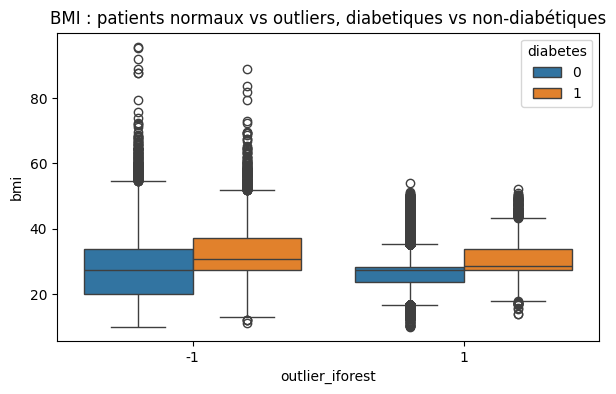

In [16]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df_outliers_compare, x='outlier_iforest', y='bmi', hue='diabetes')
plt.title("BMI : patients normaux vs outliers, diabetiques vs non-diabétiques")
plt.show()


In [17]:
numeric_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

binary_features = [col for col in X.columns if col not in numeric_features]

scaler = RobustScaler()

X_scaled_num = scaler.fit_transform(X[numeric_features])

X_normalized = pd.concat([
    pd.DataFrame(X_scaled_num, columns=numeric_features, index=X.index),
    X[binary_features].reset_index(drop=True)
], axis=1)

print("\n✅ Normalisation terminée — aperçu du dataset :")
print(X_normalized.head())



✅ Normalisation terminée — aperçu du dataset :
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.027778           0.0            1.0 -0.357983     0.571429   
1  0.305556           0.0            0.0  0.000000     0.571429   
2 -0.416667           0.0            0.0  0.000000    -0.071429   
3 -0.194444           0.0            0.0 -0.650420    -0.571429   
4  0.916667           1.0            1.0 -1.206723    -0.714286   

   blood_glucose_level  gender_Female  gender_Male  gender_Other  \
0             0.000000              1            0             0   
1            -1.016949              1            0             0   
2             0.305085              0            1             0   
3             0.254237              1            0             0   
4             0.254237              0            1             0   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                        0                     0                

In [18]:
X_normalized[numeric_features].describe()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.030948,0.07485,0.039420,0.000129,-0.194638,-0.032914
std,0.625468,0.26315,0.194593,1.115426,0.764766,0.689968
min,-1.192222,0.00000,0.000000,-2.909244,-1.642857,-1.016949
25%,-0.527778,0.00000,0.000000,-0.620168,-0.714286,-0.677966
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.472222,0.00000,0.000000,0.379832,0.285714,0.322034
max,1.027778,1.00000,1.000000,11.490756,2.285714,2.711864


In [19]:
!pip install imbalanced-learn


In [20]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# --- 1) Séparer X et y ---
X = X_normalized.copy().values
y = df_encoded['diabetes'].values

print("Avant :", Counter(y))

# --- 2) Trouver indices des classes ---
idx_minority = np.where(y == 1)[0]
idx_majority = np.where(y == 0)[0]

X_minority = X[idx_minority]
X_majority = X[idx_majority]

# --- 3) Calculer combien de nouveaux échantillons il faut ---
n_minority = len(X_minority)
n_majority = len(X_majority)
target_ratio = 0.30

# nombre final de minoritaires pour avoir 30%
n_target_minority = int((target_ratio * n_majority) / (1 - target_ratio))
n_synth = n_target_minority - n_minority
print(f"🎯 Objectif : {target_ratio*100:.0f}% de diabétiques → Générer {n_synth} échantillons synthétiques")

# --- 4) Génération synthétique type SMOTE ---
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(X_minority)
neighbors = nn.kneighbors(X_minority, return_distance=False)

synthetic_samples = []
for _ in range(n_synth):
    i = np.random.randint(0, n_minority)
    neighbor = np.random.choice(neighbors[i])
    diff = X_minority[neighbor] - X_minority[i]
    gap = np.random.random()
    synthetic_samples.append(X_minority[i] + gap * diff)

X_synthetic = np.array(synthetic_samples)
y_synthetic = np.ones(len(X_synthetic))

# --- 5) Fusionner les données originales + synthétiques ---
X_balanced = np.vstack((X_majority, X_minority, X_synthetic))
y_balanced = np.hstack((np.zeros(len(X_majority)), np.ones(len(X_minority) + len(X_synthetic))))

# --- 6) Undersampling de la classe majoritaire pour ratio 30% ---
n_final_majority = int(((1 - target_ratio) / target_ratio) * len(y_balanced[y_balanced == 1]))
X_majority_down = X_majority[np.random.choice(len(X_majority), n_final_majority, replace=False)]

X_final = np.vstack((X_majority_down, X_minority, X_synthetic))
y_final = np.hstack((np.zeros(len(X_majority_down)), np.ones(len(X_minority) + len(X_synthetic))))

# --- 7) Reconstruction DataFrame ---
df_balanced = pd.DataFrame(X_final, columns=X_normalized.columns)
df_balanced["diabetes"] = y_final.astype(int)

# --- 8) Résumé ---
print("\n✅ Répartition finale :", Counter(df_balanced["diabetes"]))
print("📊 Pourcentage final diabétiques :", 
      round(100 * Counter(df_balanced["diabetes"])[1] / len(df_balanced), 2), "%")
print("📦 Taille finale du dataset :", df_balanced.shape)


Avant : Counter({0: 91500, 1: 8500})
🎯 Objectif : 30% de diabétiques → Générer 30714 échantillons synthétiques

✅ Répartition finale : Counter({0: 91499, 1: 39214})
📊 Pourcentage final diabétiques : 30.0 %
📦 Taille finale du dataset : (130713, 16)


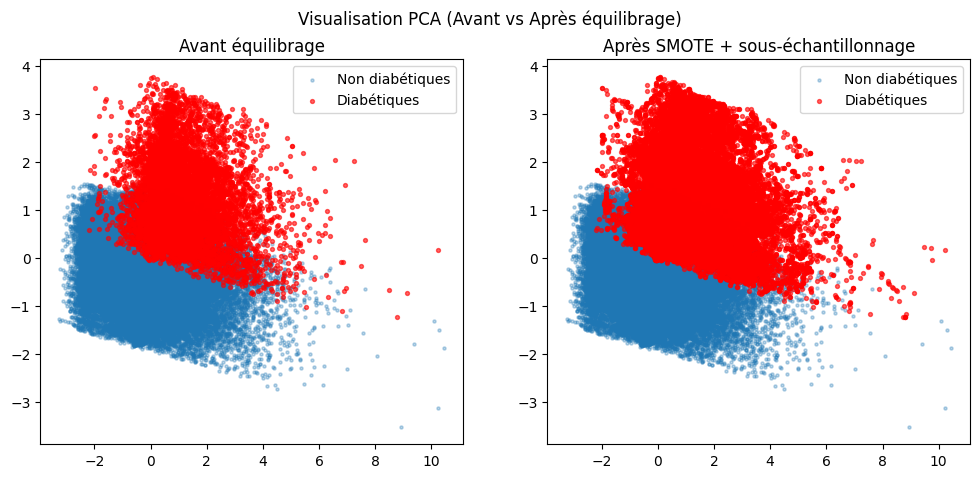

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Projection PCA avant équilibrage ---
pca = PCA(n_components=2)
X_pca_before = pca.fit_transform(X)

# --- Projection PCA après équilibrage ---
X_pca_after = pca.transform(df_balanced.drop("diabetes", axis=1).values)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Avant SMOTE
axs[0].scatter(X_pca_before[y == 0, 0], X_pca_before[y == 0, 1], s=5, alpha=0.3, label='Non diabétiques')
axs[0].scatter(X_pca_before[y == 1, 0], X_pca_before[y == 1, 1], s=8, alpha=0.6, label='Diabétiques', c='red')
axs[0].set_title("Avant équilibrage")
axs[0].legend()

# Après SMOTE + under-sampling
axs[1].scatter(X_pca_after[df_balanced["diabetes"] == 0, 0], X_pca_after[df_balanced["diabetes"] == 0, 1], s=5, alpha=0.3, label='Non diabétiques')
axs[1].scatter(X_pca_after[df_balanced["diabetes"] == 1, 0], X_pca_after[df_balanced["diabetes"] == 1, 1], s=8, alpha=0.6, label='Diabétiques', c='red')
axs[1].set_title("Après SMOTE + sous-échantillonnage")
axs[1].legend()

plt.suptitle("Visualisation PCA (Avant vs Après équilibrage)")
plt.show()


In [22]:
# Nom du fichier à sauvegarder
file_path = "diabetes_balanced_30.csv"

# Sauvegarde en CSV
df_balanced.to_csv(file_path, index=False)

print(f"✅ Dataset sauvegardé avec succès sous : {file_path}")


✅ Dataset sauvegardé avec succès sous : diabetes_balanced_30.csv


In [114]:
import os

for f in os.listdir():
    print(f)


.amlignore
.amlignore.amltmp
.ipynb_aml_checkpoints
diabetes_balanced_30.csv
diabetes_data_mining.ipynb
diabetes_data_mining.ipynb.amltmp


📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18300
           1       0.97      0.95      0.96      7843

    accuracy                           0.97     26143
   macro avg       0.97      0.97      0.97     26143
weighted avg       0.97      0.97      0.97     26143

AUC : 0.9962877760196869


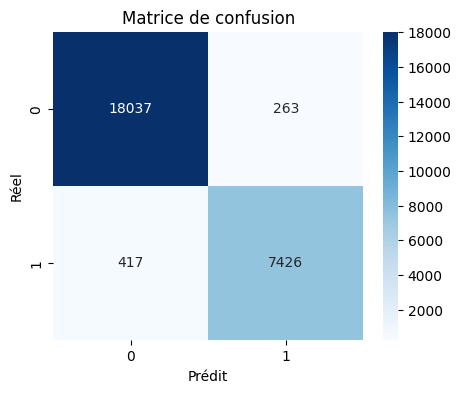

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Séparer X et y ---
X = df_balanced.drop("diabetes", axis=1)
y = df_balanced["diabetes"]

# --- 2️⃣ Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3️⃣ Modèle ---
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

# --- 4️⃣ Prédictions ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- 5️⃣ Évaluation ---
print("📊 Rapport de classification :")
print(classification_report(y_test, y_pred))
print("AUC :", roc_auc_score(y_test, y_prob))

# --- 6️⃣ Matrice de confusion ---
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()



📌 Rappel (Recall) des diabétiques selon le seuil :

🔹 Seuil 0.1 → Recall classe 1 = 0.9938
🔹 Seuil 0.2 → Recall classe 1 = 0.9879
🔹 Seuil 0.3 → Recall classe 1 = 0.9793
🔹 Seuil 0.4 → Recall classe 1 = 0.9689
🔹 Seuil 0.5 → Recall classe 1 = 0.9484

✅ Rapport de classification avec seuil ajusté :
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18300
           1       0.90      0.98      0.94      7843

    accuracy                           0.96     26143
   macro avg       0.95      0.97      0.96     26143
weighted avg       0.96      0.96      0.96     26143



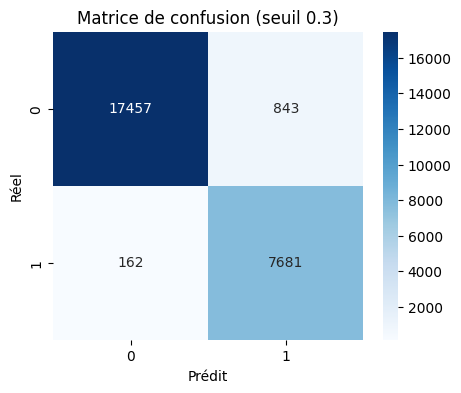

In [24]:
from sklearn.metrics import recall_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Probabilités prédites
y_prob = model.predict_proba(X_test)[:, 1]

# Test de plusieurs seuils
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
print("\n📌 Rappel (Recall) des diabétiques selon le seuil :\n")

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    print(f"🔹 Seuil {t} → Recall classe 1 = {round(recall, 4)}")

# Choisir le meilleur seuil (par ex 0.3)
best_threshold = 0.3
y_pred_best = (y_prob >= best_threshold).astype(int)

print("\n✅ Rapport de classification avec seuil ajusté :")
print(classification_report(y_test, y_pred_best))

# Matrice de confusion
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion (seuil {best_threshold})")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


🎯 Meilleur seuil (max recall) :
 Seuil        0.000000
Précision    0.300004
Recall       1.000000
F1           0.461543
Name: 0, dtype: float64 

🏆 Meilleur seuil (max F1) :
 Seuil        0.474747
Précision    0.960905
Recall       0.952697
F1           0.956783
Name: 47, dtype: float64 

⚖️ Meilleur compromis Precision/Recall :
 Seuil        0.454545
Précision    0.954453
Recall       0.956522
F1           0.955486
Name: 45, dtype: float64 



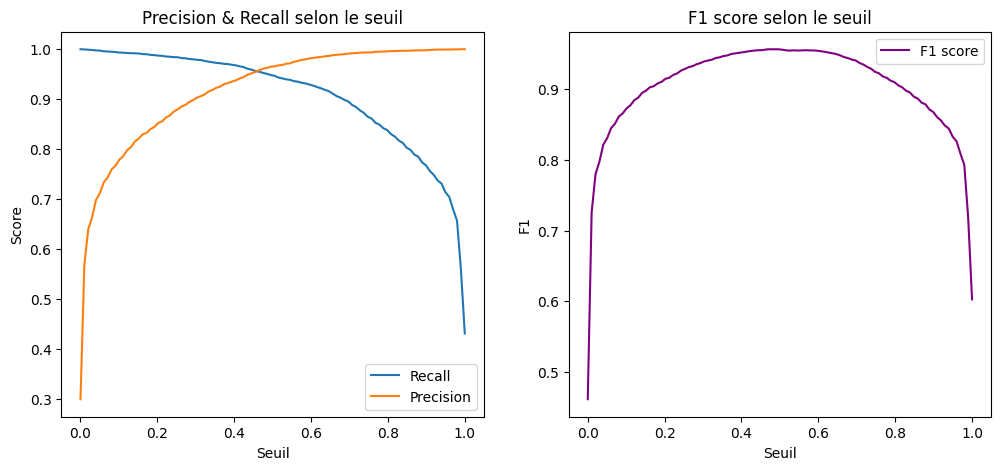

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 1️⃣ Probabilités du modèle déjà entraîné
y_scores = model.predict_proba(X_test)[:, 1]

# 2️⃣ Génération des seuils
thresholds = np.linspace(0, 1, 100)
results = []

for t in thresholds:
    y_pred_t = (y_scores >= t).astype(int)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    results.append([t, precision, recall, f1])

df_thresh = pd.DataFrame(results, columns=["Seuil", "Précision", "Recall", "F1"])

# 3️⃣ Trouver les meilleurs seuils
best_recall = df_thresh.loc[df_thresh['Recall'].idxmax()]
best_f1 = df_thresh.loc[df_thresh['F1'].idxmax()]
best_balanced = df_thresh.iloc[(df_thresh['Recall'] - df_thresh['Précision']).abs().argmin()]

print("🎯 Meilleur seuil (max recall) :\n", best_recall, "\n")
print("🏆 Meilleur seuil (max F1) :\n", best_f1, "\n")
print("⚖️ Meilleur compromis Precision/Recall :\n", best_balanced, "\n")

# 4️⃣ Graphique
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(df_thresh["Seuil"], df_thresh["Recall"], label="Recall")
plt.plot(df_thresh["Seuil"], df_thresh["Précision"], label="Precision")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Precision & Recall selon le seuil")
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_thresh["Seuil"], df_thresh["F1"], label="F1 score", color="purple")
plt.xlabel("Seuil")
plt.ylabel("F1")
plt.title("F1 score selon le seuil")
plt.legend()

plt.show()


📊 Rapport de classification (seuil = 0.47):

              precision    recall  f1-score   support

           0     0.9803    0.9828    0.9816     18300
           1     0.9597    0.9538    0.9568      7843

    accuracy                         0.9741     26143
   macro avg     0.9700    0.9683    0.9692     26143
weighted avg     0.9741    0.9741    0.9741     26143



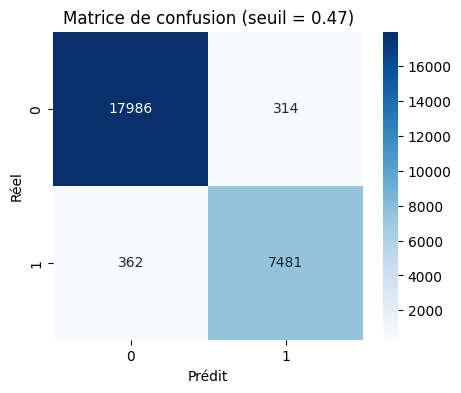

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Seuil choisi (balanced)
best_threshold = 0.47

# Prédictions selon le seuil
y_pred_best = (y_scores >= best_threshold).astype(int)

# Rapport de classification
print(f"📊 Rapport de classification (seuil = {best_threshold}):\n")
print(classification_report(y_test, y_pred_best, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion (seuil = {best_threshold})")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [31]:
!pip install xgboost==1.7.6 numba==0.57.0 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.9 MB/s eta 0:00:00:00:01
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 35.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstall

In [27]:
import os
os.environ["XGBOOST_SKIP_NAN_CHECK"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


In [29]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"



🎯 Meilleur seuil (max Recall) :
 [0.         0.30000383 1.         0.46154299]

🏆 Meilleur seuil (max F1) :
 [0.46464646 0.97390224 0.89927324 0.93510109]

⚖️ Meilleur compromis Precision/Recall :
 [1. 0. 0. 0.]


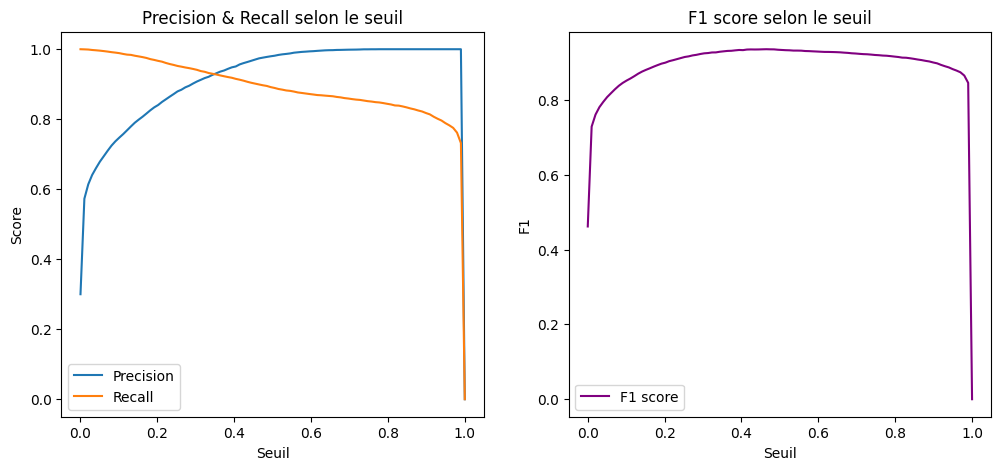

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Entrainement modèle XGBoost ---
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# --- 2️⃣ Prédiction des probabilités ---
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# --- 3️⃣ Tester différents seuils ---
thresholds = np.linspace(0, 1, 100)
results = []

for t in thresholds:
    y_pred_t = (y_prob_xgb >= t).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    results.append([t, precision, recall, f1])

results = np.array(results)

# --- 4️⃣ Trouver meilleurs seuils ---
best_recall = results[np.argmax(results[:,2])]
best_f1 = results[np.argmax(results[:,3])]
best_balance = results[np.argmin(abs(results[:,1] - results[:,2]))]

print("\n🎯 Meilleur seuil (max Recall) :\n", best_recall)
print("\n🏆 Meilleur seuil (max F1) :\n", best_f1)
print("\n⚖️ Meilleur compromis Precision/Recall :\n", best_balance)

# --- 5️⃣ Graphiques ---
plt.figure(figsize=(12,5))

# Precision vs Recall
plt.subplot(1,2,1)
plt.plot(results[:,0], results[:,1], label='Precision')
plt.plot(results[:,0], results[:,2], label='Recall')
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Precision & Recall selon le seuil")
plt.legend()

# F1 score
plt.subplot(1,2,2)
plt.plot(results[:,0], results[:,3], color="purple", label='F1 score')
plt.xlabel("Seuil")
plt.ylabel("F1")
plt.title("F1 score selon le seuil")
plt.legend()

plt.show()


📊 Rapport de classification (seuil = 0.42):

              precision    recall  f1-score   support

           0     0.9623    0.9839    0.9730     18300
           1     0.9603    0.9101    0.9345      7843

    accuracy                         0.9617     26143
   macro avg     0.9613    0.9470    0.9538     26143
weighted avg     0.9617    0.9617    0.9614     26143

AUC : 0.9927445656528497


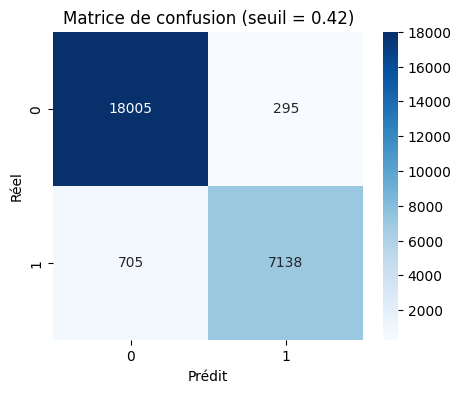

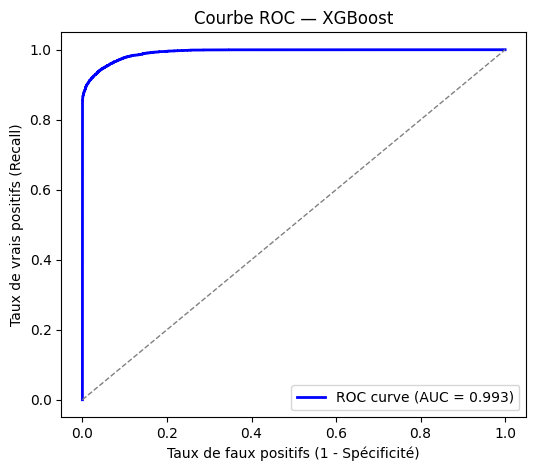

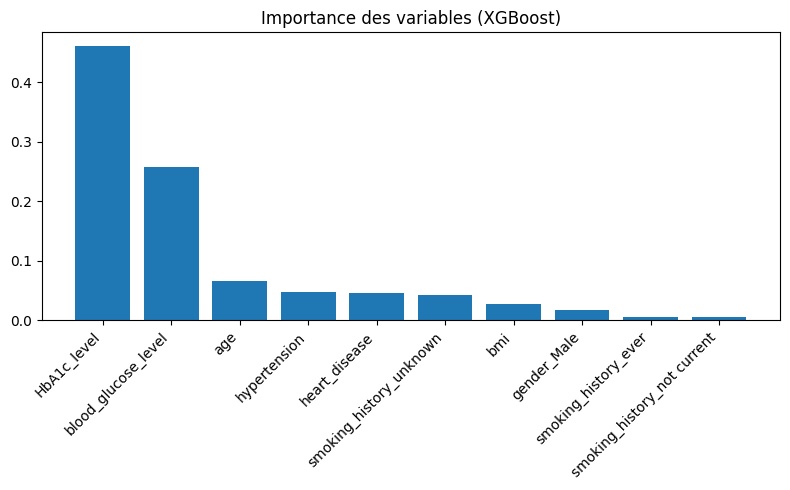

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1️⃣ Appliquer le meilleur seuil ---
best_threshold = 0.4242
y_pred_best = (y_prob_xgb >= best_threshold).astype(int)

# --- 2️⃣ Évaluation ---
print(f"📊 Rapport de classification (seuil = {best_threshold:.2f}):\n")
print(classification_report(y_test, y_pred_best, digits=4))
print("AUC :", roc_auc_score(y_test, y_prob_xgb))

# --- 3️⃣ Matrice de confusion ---
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion (seuil = {best_threshold:.2f})")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# --- 4️⃣ Courbe ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Recall)')
plt.title('Courbe ROC — XGBoost')
plt.legend()
plt.show()

# --- 5️⃣ Importance des variables ---
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Importance des variables (XGBoost)")
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), np.array(X.columns)[indices][:10], rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Séparer X et y à partir du dataset équilibré
X = df_balanced.drop("diabetes", axis=1)
y = df_balanced["diabetes"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Modèle XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)
print("✅ Modèle XGBoost entraîné")


✅ Modèle XGBoost entraîné


   Seuil  Precision    Recall        F1    FP   FN
0   0.50   0.980552  0.887161  0.931522   138  885
1   0.45   0.966329  0.900166  0.932075   246  783
2   0.40   0.946207  0.912788  0.929197   407  684
3   0.35   0.924162  0.927579  0.925867   597  568
4   0.30   0.901224  0.938799  0.919628   807  480
5   0.25   0.868504  0.952442  0.908538  1131  373
6   0.20   0.830015  0.967487  0.893494  1554  255
7   0.15   0.787633  0.979345  0.873089  2071  162
8   0.10   0.737272  0.989672  0.845027  2766   81


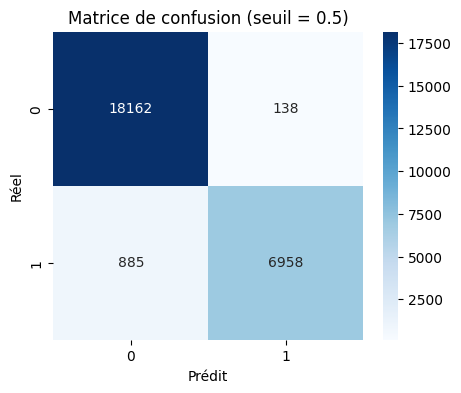

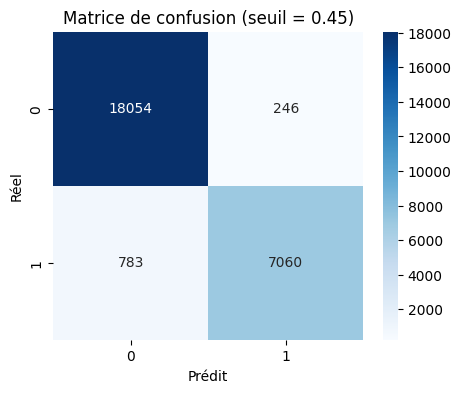

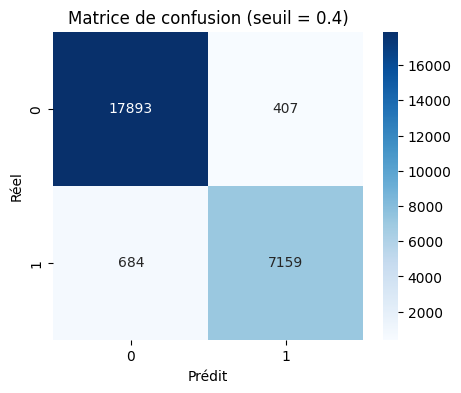

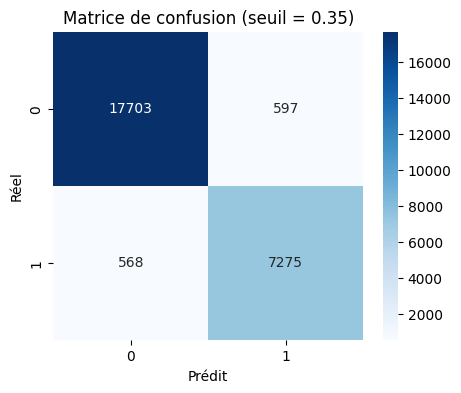

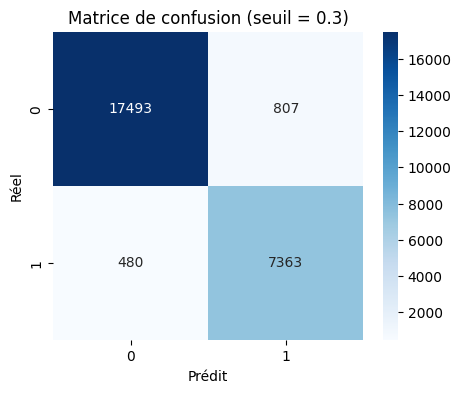

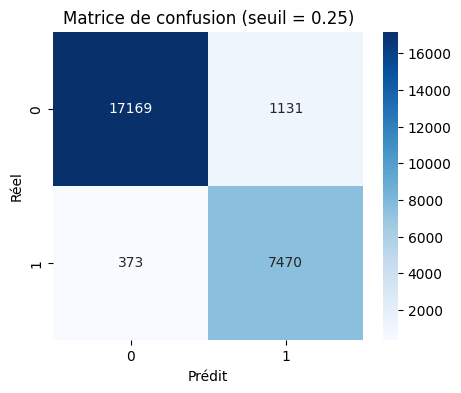

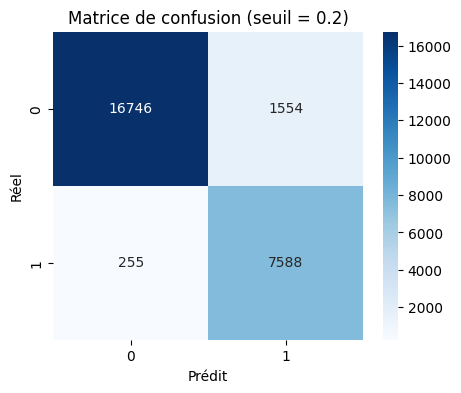

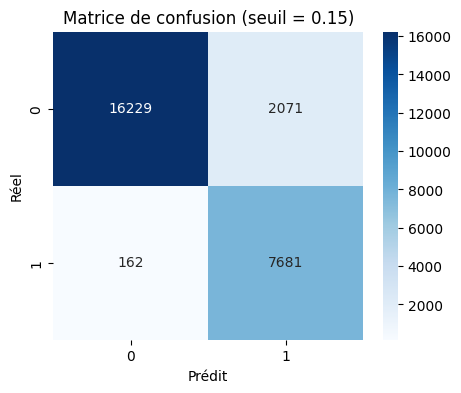

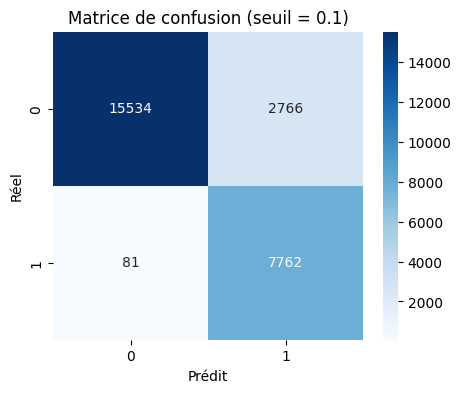

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === Liste des seuils à tester ===
seuils = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10]

# === Récupérer les probabilités du modèle ===
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# === Stocker les résultats ===
results = []

for seuil in seuils:
    y_pred_seuil = (y_prob >= seuil).astype(int)

    recall = recall_score(y_test, y_pred_seuil)
    precision = precision_score(y_test, y_pred_seuil)
    f1 = f1_score(y_test, y_pred_seuil)

    cm = confusion_matrix(y_test, y_pred_seuil)
    tn, fp, fn, tp = cm.ravel()

    results.append([seuil, precision, recall, f1, fp, fn])

# === Tableau récapitulatif ===
df_results = pd.DataFrame(results, columns=["Seuil", "Precision", "Recall", "F1", "FP", "FN"])
print(df_results)

# === Affichage des matrices pour chaque seuil ===
for seuil in seuils:
    y_pred_seuil = (y_prob >= seuil).astype(int)
    cm = confusion_matrix(y_test, y_pred_seuil)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion (seuil = {seuil})")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()


In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import joblib, json

# === 1) Base model ===
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# === 2) Search space ===
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 2, 5, 10]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rs_xgb.fit(X_train, y_train)
best_model_xgb = rs_xgb.best_estimator_

print("\n✅ Best params XGB:", rs_xgb.best_params_)

# === 3) Threshold sweep ===
y_prob_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.10, 0.51, 0.05)

rows = []
for th in thresholds:
    y_pred = (y_prob_xgb >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_xgb_results = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé XGB seuils ===")
print(df_xgb_results)

# === 4) Threshold selection ===
candidates = df_xgb_results[df_xgb_results["Recall"] >= 0.97]
if not candidates.empty:
    best_row = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row = df_xgb_results.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_xgb = best_row["Seuil"]
print(f"\n🎯 Seuil XGB retenu: {best_th_xgb:.2f}")
print(best_row)

# === 5) Save model + threshold ===
joblib.dump(best_model_xgb, "model_xgb.pkl")
json.dump({"threshold": float(best_th_xgb)}, open("threshold_xgb.json", "w"))

print("\n💾 XGBoost exporté : model_xgb.pkl & threshold_xgb.json")


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



✅ Best params XGB: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}

=== Résumé XGB seuils ===
   Seuil  Precision    Recall        F1    FP   FN
0   0.10   0.853640  0.980875  0.912845  1319  150
1   0.15   0.887767  0.975265  0.929461   967  194
2   0.20   0.910928  0.971440  0.940211   745  224
3   0.25   0.927106  0.968124  0.947171   597  250
4   0.30   0.937291  0.964299  0.950603   506  280
5   0.35   0.947713  0.959072  0.953359   415  321
6   0.40   0.957055  0.954737  0.955895   336  355
7   0.45   0.964508  0.949382  0.956885   274  397
8   0.50   0.969550  0.945939  0.957599   233  424

🎯 Seuil XGB retenu: 0.10
Seuil           0.100000
Precision       0.853640
Recall          0.980875
F1              0.912845
FP           1319.000000
FN            150.000000
Name: 0, dtype: float64

💾 XGBoost exporté : model_xgb.pkl & threshold_xgb.json


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import joblib, json

# === 1) Base model ===
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=1
)

# === 2) Search space ===
param_dist_rf = {
    'n_estimators': [120, 150, 180, 220],
    'max_depth': [None, 6, 10, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=15,
    scoring='recall',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

rs_rf.fit(X_train, y_train)
best_model_rf = rs_rf.best_estimator_

print("\n✅ Best params RF:", rs_rf.best_params_)

# === 3) Threshold sweep ===
y_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.10, 0.51, 0.05)

rows = []
for th in thresholds:
    y_pred = (y_prob_rf >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_rf_results = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé RF seuils ===")
print(df_rf_results)

# === 4) Threshold selection ===
candidates = df_rf_results[df_rf_results["Recall"] >= 0.97]
if not candidates.empty:
    best_row = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row = df_rf_results.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_rf = best_row["Seuil"]
print(f"\n🎯 Seuil RF retenu: {best_th_rf:.2f}")
print(best_row)

# === 5) Save model + threshold ===
joblib.dump(best_model_rf, "model_rf.pkl")
json.dump({"threshold": float(best_th_rf)}, open("threshold_rf.json", "w"))

print("\n💾 RandomForest exporté : model_rf.pkl & threshold_rf.json")


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=  10.5s
[CV] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=  10.0s
[CV] END bootstrap=True, max_depth=14, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=180; total time=   9.0s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   7.1s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   6.8s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=180; total time=   5.7s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=180; to

In [38]:
pip install lightgbm --no-cache-dir


Note: you may need to restart the kernel to use updated packages.


In [39]:
import lightgbm as lgb



=== Résumé seuils LOGREG ===
   Seuil  Precision    Recall        F1    FP   FN
0   0.10   0.547686  0.989927  0.705209  6412   79
1   0.15   0.590927  0.979855  0.737241  5320  158
2   0.20   0.624129  0.970929  0.759828  4586  228
3   0.25   0.655214  0.960474  0.779007  3964  310
4   0.30   0.684733  0.950402  0.795985  3432  389
5   0.35   0.710412  0.938671  0.808744  3001  481
6   0.40   0.734300  0.922861  0.817853  2619  605
7   0.45   0.756959  0.905011  0.824390  2279  745
8   0.50   0.777454  0.885503  0.827969  1988  898

🎯 Seuil LOGREG retenu: 0.10
Seuil           0.100000
Precision       0.547686
Recall          0.989927
F1              0.705209
FP           6412.000000
FN             79.000000
Name: 0, dtype: float64

📊 Rapport final (LogReg):
              precision    recall  f1-score   support

           0     0.9934    0.6496    0.7855     18300
           1     0.5477    0.9899    0.7052      7843

    accuracy                         0.7517     26143
   macro avg

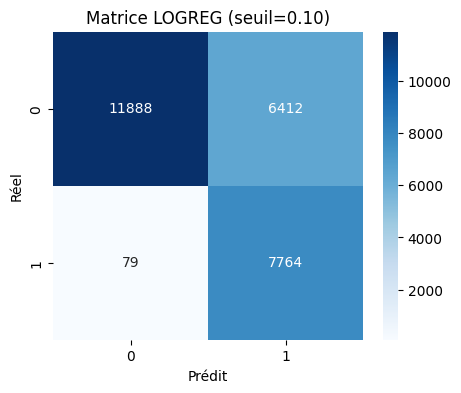

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# === 1️⃣ Entraînement simple ===
logreg = LogisticRegression(max_iter=500, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train, y_train)

# === 2️⃣ Probabilités ===
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

# === 3️⃣ Sweep des seuils ===
thresholds = np.arange(0.10, 0.51, 0.05)
rows = []

for th in thresholds:
    y_pred = (y_prob_logreg >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_logreg = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé seuils LOGREG ===")
print(df_logreg)

# === 4️⃣ Choix du meilleur seuil ===
candidates = df_logreg[df_logreg["Recall"] >= 0.97]
if not candidates.empty:
    best_row_logreg = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row_logreg = df_logreg.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_logreg = best_row_logreg["Seuil"]
print(f"\n🎯 Seuil LOGREG retenu: {best_th_logreg:.2f}")
print(best_row_logreg)

# === 5️⃣ Rapport final ===
y_pred_final_logreg = (y_prob_logreg >= best_th_logreg).astype(int)
print("\n📊 Rapport final (LogReg):")
print(classification_report(y_test, y_pred_final_logreg, digits=4))

# === 6️⃣ Matrice de confusion ===
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_final_logreg), annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice LOGREG (seuil={best_th_logreg:.2f})")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.show()


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np, pandas as pd, joblib, json

# === 1️⃣ Base model ===
logreg_base = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')

# === 2️⃣ Search space ===
param_dist_logreg = {
    "C": np.logspace(-3, 2, 10),   # regularization strength
    "penalty": ["l2", "none"],     # type of regularization
    "solver": ["lbfgs", "liblinear"]  # solvers compatible with binary
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# === 3️⃣ RandomizedSearch ===
rs_logreg = RandomizedSearchCV(
    estimator=logreg_base,
    param_distributions=param_dist_logreg,
    n_iter=12,
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rs_logreg.fit(X_train, y_train)

best_logreg = rs_logreg.best_estimator_
print("\n✅ Best hyperparams LOGREG :", rs_logreg.best_params_)

# === 4️⃣ Compute probability + sweep thresholds ===
y_prob_logreg_opt = best_logreg.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.10, 0.51, 0.05)

rows = []
for th in thresholds:
    y_pred = (y_prob_logreg_opt >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_results_logreg_opt = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé seuils LOGREG OPTIMISÉ ===")
print(df_results_logreg_opt)

# === 5️⃣ Select best threshold ===
candidates = df_results_logreg_opt[df_results_logreg_opt["Recall"] >= 0.97]
if not candidates.empty:
    best_row_logreg_opt = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row_logreg_opt = df_results_logreg_opt.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_logreg_opt = best_row_logreg_opt["Seuil"]
print(f"\n🎯 Seuil LOGREG OPT retenu: {best_th_logreg_opt:.2f}")
print(best_row_logreg_opt)

# === 6️⃣ Final report ===
y_pred_final = (y_prob_logreg_opt >= best_th_logreg_opt).astype(int)
print("\n📊 Rapport final LOGREG OPT :")
print(classification_report(y_test, y_pred_final, digits=4))

# === 7️⃣ Save model + threshold ===
joblib.dump(best_logreg, "model_logreg.pkl")

with open("threshold_logreg.json", "w") as f:
    json.dump({"threshold": float(best_th_logreg_opt)}, f)

print("\n💾 Modèle et seuil sauvegardés ✅")


Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Best hyperparams LOGREG : {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01291549665014884}

=== Résumé seuils LOGREG OPTIMISÉ ===
   Seuil  Precision    Recall        F1    FP   FN
0   0.10   0.534538  0.991585  0.694623  6772   66
1   0.15   0.579094  0.982532  0.728700  5601  137
2   0.20   0.614183  0.972842  0.752985  4793  213
3   0.25   0.646345  0.963789  0.773774  4136  284
4   0.30   0.676013  0.952952  0.790941  3582  369
5   0.35   0.704979  0.942369  0.806570  3093  452
6   0.40   0.730584  0.925921  0.816735  2678  581
7   0.45   0.755409  0.908071  0.824735  2306  721
8   0.50   0.777765  0.886651  0.828646  1987  889

🎯 Seuil LOGREG OPT retenu: 0.10
Seuil           0.100000
Precision       0.534538
Recall          0.991585
F1              0.694623
FP           6772.000000
FN             66.000000
Name: 0, dtype: float64

📊 Rapport final LOGREG OPT :
              precision    recall  f1-score   support

  

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='no

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 31371, number of negative: 73199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 104570, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298

=== Résumé seuils LightGBM ===
   Seuil  Precision    Recall        F1    FP   FN
0   0.10   0.759839  0.989545  0.859611  2453   82
1   0.15   0.812560  0.978325  0.887770  1770  170
2   0.20   0.852921  0.967869  0.906767  1309  252
3   0.25   0.887518  0.953717  0.919427   948  363
4   0.30   0.914211  0.941604  0.927706   693  458
5   0.35   0.936547  0.

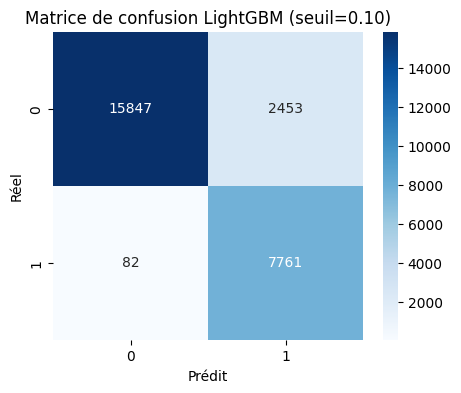

In [42]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# === 1️⃣ Entraînement LightGBM baseline ===
lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgb.fit(X_train, y_train)

# === 2️⃣ Probabilités ===
y_prob_lgb = lgb.predict_proba(X_test)[:, 1]

# === 3️⃣ Test des seuils ===
thresholds = np.arange(0.10, 0.51, 0.05)
rows = []

for th in thresholds:
    y_pred = (y_prob_lgb >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_lgb = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé seuils LightGBM ===")
print(df_lgb)

# === 4️⃣ Choix du meilleur seuil ===
candidates = df_lgb[df_lgb["Recall"] >= 0.97]
if not candidates.empty:
    best_row_lgb = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row_lgb = df_lgb.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_lgb = best_row_lgb["Seuil"]
print(f"\n🎯 Seuil retenu (baseline LGBM): {best_th_lgb:.2f}")
print(best_row_lgb)

# === 5️⃣ Rapport final ===
y_pred_final = (y_prob_lgb >= best_th_lgb).astype(int)
print("\n📊 Rapport final LightGBM :")
print(classification_report(y_test, y_pred_final, digits=4))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion LightGBM (seuil={best_th_lgb:.2f})")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=0.1668100537200059, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1668100537200059, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .....C=0.1668100537200059, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.046415888336127795, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.046415888336127795, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.046415888336127795, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...C=2.1544346900318843, penalty=none, solver=lbfgs; total time=   0.3s
[CV] END ...C=2.1544346900318843, penalty=none, solver=lbfgs; total time=   0.3s
[CV] END ..C=0.0035938136638046254, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...C=0.046415888336127795, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...C=0.046415888336127795, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ..............C=100.0, penal

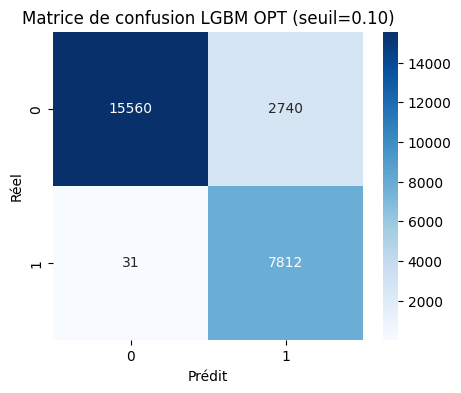

[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=-1, n_estimators=150, num_leaves=63, reg_lambda=1, subsample=0.8; total time=  25.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20914, number of negative: 48800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 69714, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END colsample_bytree=0.8, learning_rate=0.03, max_depth=-1, n_estimators=150, num_leaves=63, reg_lambda=1, subsample=0.8; total time=  29.8s
[LightGBM] [Warning] Found whitespace in feature_names, replace with u

In [43]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# === 1️⃣ Base model ===
lgb = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# === 2️⃣ Search space (compact & fast) ===
param_dist = {
    'n_estimators': [150, 250, 350, 450],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [-1, 4, 6, 8],
    'num_leaves': [15, 31, 63],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_lambda': [0, 1, 5, 10]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rs_lgb = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=20,                 # ✅ Enough but still fast
    scoring='recall',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rs_lgb.fit(X_train, y_train)

print("\n✅ Best params LightGBM optimized:")
print(rs_lgb.best_params_)

best_model_lgb_opt = rs_lgb.best_estimator_

# === 3️⃣ Sweeping thresholds again ===
y_prob = best_model_lgb_opt.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.10, 0.51, 0.05)

rows = []
for th in thresholds:
    y_pred = (y_prob >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    rows.append([th, p, r, f1, fp, fn])

df_opt = pd.DataFrame(rows, columns=["Seuil","Precision","Recall","F1","FP","FN"])
print("\n=== Résumé seuils LightGBM OPT ===")
print(df_opt)

# === 4️⃣ Best threshold selection ===
candidates = df_opt[df_opt["Recall"] >= 0.97]
if not candidates.empty:
    best_row_lgb_opt = candidates.sort_values(["FN","F1"], ascending=[True, False]).iloc[0]
else:
    best_row_lgb_opt = df_opt.sort_values(["Recall","F1"], ascending=[False, False]).iloc[0]

best_th_lgb_opt = best_row_lgb_opt["Seuil"]
print(f"\n🎯 Seuil retenu (LGBM OPT): {best_th_lgb_opt:.2f}")
print(best_row_lgb_opt)

# === 5️⃣ Final test report ===
y_pred_final = (y_prob >= best_th_lgb_opt).astype(int)
print("\n📊 Rapport final LightGBM OPT :")
print(classification_report(y_test, y_pred_final, digits=4))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion LGBM OPT (seuil={best_th_lgb_opt:.2f})")
plt.xlabel("Prédit"); plt.ylabel("Réel")
plt.show()


In [45]:
import joblib, json

# === 1️⃣ Sauvegarde des modèles ===
joblib.dump(best_model_xgb, "model_xgb.pkl")
joblib.dump(best_model_rf, "model_rf.pkl")
joblib.dump(best_logreg, "model_logreg.pkl")
joblib.dump(best_model_lgb_opt, "model_lgb.pkl")

# === 2️⃣ Sauvegarde des seuils ===
thresholds_dict = {
    "xgb": float(best_th_xgb),
    "rf": float(best_th_rf),
    "logreg": float(best_th_logreg),
    "lgb": float(best_th_lgb)
}

with open("thresholds.json", "w") as f:
    json.dump(thresholds_dict, f, indent=4)

print("\n✅ Sauvegarde terminée !")
print("📁 Fichiers créés : model_xgb.pkl, model_rf.pkl, model_logreg.pkl, model_lgb.pkl, thresholds.json")



✅ Sauvegarde terminée !
📁 Fichiers créés : model_xgb.pkl, model_rf.pkl, model_logreg.pkl, model_lgb.pkl, thresholds.json


In [46]:
print(list(X_train.columns))


['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_Female', 'gender_Male', 'gender_Other', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current', 'smoking_history_unknown']


In [49]:
!az account show


{
  "environmentName": "AzureCloud",
  "homeTenantId": "4965db42-7d9d-4f8a-9161-4a17389d712a",
  "id": "70c34068-eea9-44dd-a857-783e7a7561bb",
  "isDefault": true,
  "managedByTenants": [],
  "name": "Azure for Students",
  "state": "Enabled",
  "tenantDefaultDomain": "benalikawtar1110gmail.onmicrosoft.com",
  "tenantDisplayName": "Répertoire par défaut",
  "tenantId": "4965db42-7d9d-4f8a-9161-4a17389d712a",
  "user": {
    "name": "benalikawtar1110@gmail.com",
    "type": "user"
  }
}


In [1]:
!az ml environment create \
  --name diabetes-env \
  --file env.yml



**************************************************************************************************************
* WARNING:                                                                                                   *
* Extension "azure-cli-ml" cannot be used along with extension "ml". This may result in unexpected behaviour.*
* Please remove azure-cli-ml extension by running  "az extension remove -n azure-cli-ml                      *
**************************************************************************************************************
                

The yaml file you provided does not match the prescribed schema for Environment yaml files and/or has the following issues:

Error: 

Details: Validation for EnvironmentSchema failed

(x) _schema:
- It looks like you are trying to specify a conda file for the --file/-f argument. --file/-f is reserved for the Azure ML Environment definition (see schema here: https://aka.ms/ml-cli-v2-environment-yaml-reference). To specify a

In [50]:
!az ml model deploy \
  --name diabetes-api \
  --model-path model_xgb.pkl \
  --environment env.yml \
  --entry-script score.py \
  --instance-type Standard_DS2_v2 \
  --endpoint-name diabetes-endpoint \
  --auth-mode key


ambiguous option: --environment could match --environment-name, --environment-version, --environment-directory

Examples from AI knowledge base:
https://aka.ms/cli_ref
Read more about the command in reference docs


In [2]:
!az extension remove -n azure-cli-ml


In [3]:
!az ml environment create \
  --name diabetes-env \
  --conda-file env.yml \
  --image mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04 \
  --version 1


{
  "conda_file": {
    "dependencies": [
      "python=3.10",
      "pip",
      {
        "pip": [
          "numpy",
          "pandas",
          "scikit-learn",
          "joblib",
          "xgboost"
        ]
      }
    ],
    "name": "diabetes-env"
  },
  "creation_context": {
    "created_at": "2025-11-09T17:13:16.711407+00:00",
    "created_by": "KAWTAR BENALI",
    "created_by_type": "User",
    "last_modified_at": "2025-11-09T17:13:16.711407+00:00",
    "last_modified_by": "KAWTAR BENALI",
    "last_modified_by_type": "User"
  },
  "id": "azureml:/subscriptions/70c34068-eea9-44dd-a857-783e7a7561bb/resourceGroups/rg-diabetes-project/providers/Microsoft.MachineLearningServices/workspaces/ws-diabetes/environments/diabetes-env/versions/1",
  "image": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
  "name": "diabetes-env",
  "os_type": "linux",
  "resourceGroup": "rg-diabetes-project",
  "tags": {},
  "version": "1"
}


In [5]:
!az ml model create \
  --name diabetes-xgb-model \
  --version 1 \
  --path model_xgb.pkl \
  --type custom_model


Uploading model_xgb.pkl (< 1 MB): 100%|████| 2.59M/2.59M [00:00<00:00, 11.1MB/s]


{
  "creation_context": {
    "created_at": "2025-11-09T17:19:26.966365+00:00",
    "created_by": "KAWTAR BENALI",
    "created_by_type": "User",
    "last_modified_at": "2025-11-09T17:19:26.966365+00:00",
    "last_modified_by": "KAWTAR BENALI",
    "last_modified_by_type": "User"
  },
  "id": "azureml:/subscriptions/70c34068-eea9-44dd-a857-783e7a7561bb/resourceGroups/rg-diabetes-project/providers/Microsoft.MachineLearningServices/workspaces/ws-diabetes/models/diabetes-xgb-model/versions/1",
  "name": "diabetes-xgb-model",
  "path": "azureml://subscriptions/70c34068-eea9-44dd-a857-783e7a7561bb/resourceGroups/rg-diabetes-project/workspaces/ws-diabetes/datastores/workspaceblobstore/paths/LocalUpload/11030a9172c55b5f7ab4da4e51e97f771124a790c1b734a2ea01237bc1035d63/model_xgb.pkl",
  "properties": {},
  "resourceGroup": "rg-diabetes-project",
  "stage": "Development",
  "tags": {},
  "type": "custom_model",


In [8]:
!az provider register --namespace Microsoft.MachineLearningServices
!az provider register --namespace Microsoft.ContainerRegistry
!az provider register --namespace Microsoft.Batch
!az provider register --namespace Microsoft.Storage


Registering is still on-going. You can monitor using 'az provider show -n Microsoft.Batch'


In [9]:
!az provider show --namespace Microsoft.MachineLearningServices --query "registrationState"


"Registered"


In [11]:
!az ml online-endpoint delete --name diabetes-endpoint-kawtar --yes


Delete request initiated. If you interrupt this command or it times out while waiting for deletion to complete, status can be checked using `az ml online-endpoint show -n diabetes-endpoint-kawtar`



In [12]:
!az ml online-endpoint create \
  --name diabetes-endpoint-kawtar \
  --auth-mode key


(SubscriptionNotRegistered) Resource provider [N/A] isn't registered with Subscription [N/A]. Please see troubleshooting guide, available here: https://aka.ms/register-resource-provider
Code: SubscriptionNotRegistered
Message: Resource provider [N/A] isn't registered with Subscription [N/A]. Please see troubleshooting guide, available here: https://aka.ms/register-resource-provider


In [15]:
!az provider list --query "[].{Namespace:namespace, Status:registrationState}" -o table


Namespace                                                Status
-------------------------------------------------------  -------------
Microsoft.ManagedIdentity                                Registered
Microsoft.ContainerRegistry                              Registered
Microsoft.Notebooks                                      Registered
Microsoft.ContainerInstance                              Registered
Microsoft.Batch                                          Registered
Microsoft.CloudShell                                     Registered
Microsoft.OperationalInsights                            Registered
Microsoft.KeyVault                                       Registered
microsoft.insights                                       Registered
Microsoft.MachineLearningServices                        Registered
Microsoft.Compute                                        Registered
Microsoft.Network                                        Registered
Microsoft.Storage                                

In [14]:
!az provider register --namespace Microsoft.MachineLearningServices


In [16]:
!az ml online-deployment create \
  --name xgb-deploy \
  --endpoint-name diabetes-endpoint-kawtar \
  --model diabetes-xgb-model:1 \
  --environment diabetes-env:1 \
  --instance-type Standard_DS2_v2 \
  --instance-count 1 \
  --code-path . \
  --entry-script score.py


the following arguments are required: --file/-f

Examples from AI knowledge base:
az ml online-deployment create --file deployment.yaml --resource-group my-resource-group --workspace-name my-workspace
Create a deployment from a YAML specification file

https://aka.ms/cli_ref
Read more about the command in reference docs


In [17]:
!az ml online-deployment create --file deployment.yaml


The command failed with an unexpected error. Here is the traceback:
local variable 'debug' referenced before assignment
Traceback (most recent call last):
  File "/opt/az/extensions/ml/azext_mlv2/manual/vendored_curated_sdk/azure/ai/ml/_utils/utils.py", line 339, in load_yaml
    return yaml.safe_load(f)
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/yaml/__init__.py", line 125, in safe_load
    return load(stream, SafeLoader)
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/yaml/__init__.py", line 81, in load
    return loader.get_single_data()
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/yaml/constructor.py", line 49, in get_single_data
    node = self.get_single_node()
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/yaml/composer.py", line 35, in get_single_node
    if not self.check_event(StreamEndEvent):
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/yaml/parser.py", line 98, in check_event
  

In [18]:
!az ml environment list --output table


Name
--------------------------------------------------
diabetes-env
AzureML-AI-Studio-Development
AzureML-ACPT-pytorch-1.13-py38-cuda11.7-gpu
AzureML-ACPT-pytorch-1.12-py38-cuda11.6-gpu
AzureML-ACPT-pytorch-1.12-py39-cuda11.6-gpu
AzureML-ACPT-pytorch-1.11-py38-cuda11.5-gpu
AzureML-ACPT-pytorch-1.11-py38-cuda11.3-gpu
AzureML-responsibleai-0.21-ubuntu20.04-py38-cpu
AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu
AzureML-tensorflow-2.5-ubuntu20.04-py38-cuda11-gpu
AzureML-tensorflow-2.6-ubuntu20.04-py38-cuda11-gpu
AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu
AzureML-sklearn-1.0-ubuntu20.04-py38-cpu
AzureML-pytorch-1.10-ubuntu18.04-py38-cuda11-gpu
AzureML-pytorch-1.9-ubuntu18.04-py37-cuda11-gpu
AzureML-pytorch-1.8-ubuntu18.04-py37-cuda11-gpu
AzureML-sklearn-0.24-ubuntu18.04-py37-cpu
AzureML-lightgbm-3.2-ubuntu18.04-py37-cpu
AzureML-pytorch-1.7-ubuntu18.04-py37-cuda11-gpu
AzureML-tensorflow-2.4-ubuntu18.04-py37-cuda11-gpu
AzureML-Triton
AzureML-Designer-Score
AzureML-Dask-GPU
AzureML-

In [19]:
!az ml environment update \
  --name diabetes-env \
  --version 1 \
  --set tags.inference=true


{
  "conda_file": {
    "dependencies": [
      "python=3.10",
      "pip",
      {
        "pip": [
          "numpy",
          "pandas",
          "scikit-learn",
          "joblib",
          "xgboost"
        ]
      }
    ],
    "name": "diabetes-env"
  },
  "creation_context": {
    "created_at": "2025-11-09T17:13:16.711407+00:00",
    "created_by": "KAWTAR BENALI",
    "created_by_type": "User",
    "last_modified_at": "2025-11-09T17:13:16.711407+00:00",
    "last_modified_by": "KAWTAR BENALI",
    "last_modified_by_type": "User"
  },
  "id": "azureml:/subscriptions/70c34068-eea9-44dd-a857-783e7a7561bb/resourceGroups/rg-diabetes-project/providers/Microsoft.MachineLearningServices/workspaces/ws-diabetes/environments/diabetes-env/versions/1",
  "image": "mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
  "name": "diabetes-env",
  "os_type": "linux",
  "resourceGroup": "rg-diabetes-project",
  "tags": {
    "inference": "True"
  },
  "version": "1"
}


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# === Charger le dataset nettoyé ===
df_encoded = pd.read_csv("diabetes_balanced_30.csv")

print("✅ Dataset chargé avec succès !")
print("Dimensions :", df_encoded.shape)
print(df_encoded.head())

# === Définir les variables ===
X = df_encoded.drop("diabetes", axis=1)
y = df_encoded["diabetes"]

# === Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("\n✅ Split terminé avec succès :")
print("Taille X_train :", X_train.shape)
print("Taille X_test :", X_test.shape)
print("Répartition y_test :")
print(y_test.value_counts(normalize=True))


✅ Dataset chargé avec succès !
Dimensions : (130713, 16)
        age  hypertension  heart_disease       bmi  HbA1c_level  \
0 -0.166667           0.0            0.0 -0.670588    -0.714286   
1  0.750000           0.0            0.0  0.000000     0.142857   
2 -0.277778           0.0            0.0  1.499160     0.571429   
3  0.444444           0.0            0.0 -0.754622     0.214286   
4  0.555556           0.0            0.0  0.000000    -0.571429   

   blood_glucose_level  gender_Female  gender_Male  gender_Other  \
0             0.000000            1.0          0.0           0.0   
1             0.084746            0.0          1.0           0.0   
2             0.254237            0.0          1.0           0.0   
3             0.338983            1.0          0.0           0.0   
4             0.338983            1.0          0.0           0.0   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                      0.0                   0.0       


📊 Comparatif des modèles :



,Modèle,Seuil,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.1,0.949,0.863,0.985,0.920,0.997
3,LightGBM,0.1,0.894,0.740,0.997,0.850,0.996
1,RandomForest,0.1,0.880,0.715,0.998,0.833,0.997
2,LogisticRegression,0.1,0.737,0.534,0.992,0.694,0.964


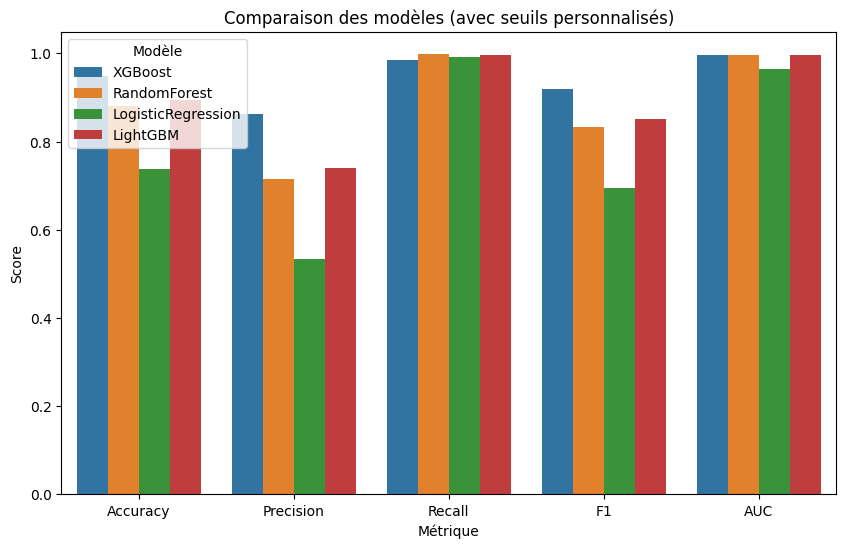

In [6]:
import joblib
import json
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1️⃣ Charger les modèles ===
models = {
    "XGBoost": joblib.load("model_xgb.pkl"),
    "RandomForest": joblib.load("model_rf.pkl"),
    "LogisticRegression": joblib.load("model_logreg.pkl"),
    "LightGBM": joblib.load("model_lgb.pkl")
}

# === 2️⃣ Charger les seuils ===
with open("thresholds.json", "r") as f:
    thresholds = json.load(f)

# === 3️⃣ Dictionnaire des correspondances exactes ===
key_map = {
    "XGBoost": "xgb",
    "RandomForest": "rf",
    "LogisticRegression": "logreg",
    "LightGBM": "lgb"
}

# === 4️⃣ Calcul des performances ===
results = []

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    key = key_map[name]              # correspondance exacte
    th = float(thresholds[key])      # lecture du seuil

    y_pred = (y_prob >= th).astype(int)

    results.append({
        "Modèle": name,
        "Seuil": round(th, 2),
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1": round(f1_score(y_test, y_pred), 3),
        "AUC": round(roc_auc_score(y_test, y_prob), 3)
    })

# === 5️⃣ Tableau comparatif ===
df_results = pd.DataFrame(results)
print("\n📊 Comparatif des modèles :\n")
display(df_results.sort_values(by="F1", ascending=False))

# === 6️⃣ Visualisation graphique ===
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_results.melt(id_vars=["Modèle"], value_vars=["Accuracy", "Precision", "Recall", "F1", "AUC"]),
    x="variable", y="value", hue="Modèle"
)
plt.title("Comparaison des modèles (avec seuils personnalisés)")
plt.ylabel("Score")
plt.xlabel("Métrique")
plt.legend(title="Modèle")
plt.show()



🧩 XGBoost


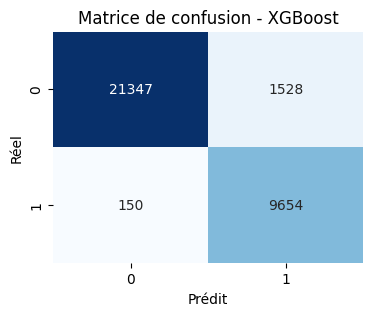

Vrais négatifs : 21347, Faux positifs : 1528
Faux négatifs : 150, Vrais positifs : 9654
✅ Excellent équilibre : le modèle détecte bien les malades sans trop de faux positifs.

🧩 RandomForest


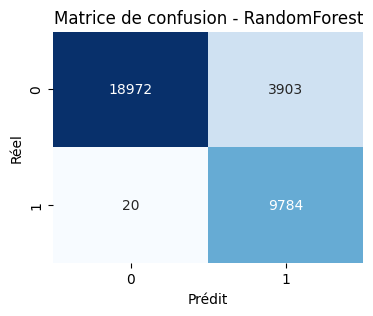

Vrais négatifs : 18972, Faux positifs : 3903
Faux négatifs : 20, Vrais positifs : 9784
⚠️ Très bon rappel mais faible précision → trop de non-malades sont détectés comme malades.

🧩 LogisticRegression


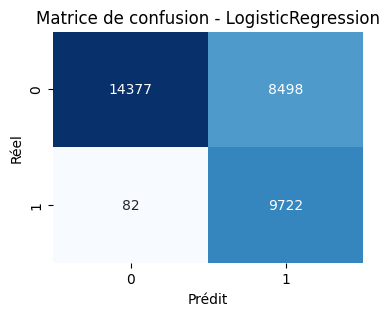

Vrais négatifs : 14377, Faux positifs : 8498
Faux négatifs : 82, Vrais positifs : 9722
⚠️ Très bon rappel mais faible précision → trop de non-malades sont détectés comme malades.

🧩 LightGBM


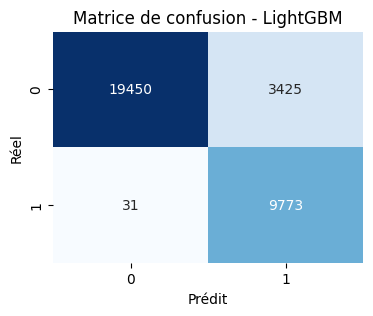

Vrais négatifs : 19450, Faux positifs : 3425
Faux négatifs : 31, Vrais positifs : 9773
⚠️ Très bon rappel mais faible précision → trop de non-malades sont détectés comme malades.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === 1️⃣ Fonction pour afficher la matrice de confusion ===
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()
    return cm

# === 2️⃣ Visualiser pour chaque modèle ===
for name, model in models.items():
    key = key_map[name]
    th = float(thresholds[key])
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= th).astype(int)
    
    print(f"\n🧩 {name}")
    cm = plot_conf_matrix(y_test, y_pred, name)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"Vrais négatifs : {tn}, Faux positifs : {fp}")
    print(f"Faux négatifs : {fn}, Vrais positifs : {tp}")
    
    # === Analyse clinique automatique ===
    if recall_score(y_test, y_pred) > 0.95 and precision_score(y_test, y_pred) > 0.80:
        print("✅ Excellent équilibre : le modèle détecte bien les malades sans trop de faux positifs.")
    elif recall_score(y_test, y_pred) > 0.95:
        print("⚠️ Très bon rappel mais faible précision → trop de non-malades sont détectés comme malades.")
    elif precision_score(y_test, y_pred) > 0.85:
        print("ℹ️ Bonne précision mais risque de rater certains vrais malades.")
    else:
        print("❌ Modèle à éviter : il ne parvient pas à bien équilibrer rappel et précision.")
